### Import libraries

In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.utils import resample

In [2]:
DATA_ROOT = "data"

## Funkcje

In [3]:
# wczytywanie 2 df i merge po nazwie kolumny
def load_and_merge(df1_name: str, df2_name: str, merge_on: str) -> pd.DataFrame:
    df1_path = os.path.join(DATA_ROOT, df1_name)
    df2_path = os.path.join(DATA_ROOT, df2_name)
    df1 =  pd.read_csv(df1_path)
    df2 =  pd.read_csv(df2_path)

    return df1.merge(df2, on=merge_on)

In [4]:
# oddzielenie df względem wartości NaN w kolumnie z ground truthami
def separate_df_by_label(input_df: pd.DataFrame) -> tuple:
    return input_df[input_df["Attrition"].isna()], input_df[~input_df["Attrition"].isna()]

In [5]:
# usunięcie wartości odstających, lower i upper boundaries jako parametry domyślne od 10 do 90 percentyla
def delete_outliers(df: pd.DataFrame, lower_boundary=0.1, upper_boundary=0.9) -> pd.DataFrame:
    lower_p = df.quantile(lower_boundary)
    upper_p = df.quantile(upper_boundary)
    iqr = upper_p - lower_p
    low_boundary = (lower_p - 1.5 * iqr)
    upp_boundary = (upper_p + 1.5 * iqr)
    num_of_outliers_l = (df[iqr.index] < low_boundary).sum()
    num_of_outliers_u = (df[iqr.index] > upp_boundary).sum()
    outliers_iqr = pd.DataFrame({'lower_boundary':low_boundary, 'upper_boundary':upp_boundary,'num_of_outliers_L':num_of_outliers_l, 'num_of_outliers_U':num_of_outliers_u})
    for row in outliers_iqr.iterrows():
        df = df[(df[row[0]] >= row[1]['lower_boundary']) & (df[row[0]] <= row[1]['upper_boundary'])]

    return df

In [6]:
# zamiana wartości kategorycznych na binarne
def get_one_hot_encoding_df(input_df: pd.DataFrame, columns: list) -> pd.DataFrame:
    return pd.get_dummies(input_df, columns=columns, drop_first=True).rename(columns={"Attrition_Yes": "Attrition"})

In [7]:
# usunięcie niechcianych kolumn z df
def drop_columns(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    for column in columns:
        df.drop(column, axis=1, inplace=True)

    return df

In [8]:
# standaryzacja
def get_standardized_df(df: pd.DataFrame, cols_to_scale: list) -> pd.DataFrame:
    result = df.copy(deep=True)
    scaler = StandardScaler()
    scaler.fit(result[cols_to_scale])
    result[cols_to_scale] = scaler.transform(result[cols_to_scale])
    return result

In [9]:
# normalizacja
def get_normalized_df(df: pd.DataFrame) -> pd.DataFrame:
    return (df-df.min()) / (df.max() - df.min())

## Load data

In [10]:
df = load_and_merge("df1.csv", "df2.csv", "EmployeeNumber")

In [11]:
df.head()

,EmployeeNumber,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,YearlyIncome
0,104,30.0,Travel_Rarely,852.0,Research & Development,1.0,1.0,Life Sciences,1.0,4.0,...,2.0,10.0,1.0,2.0,10.0,8.0,3.0,0.0,No,61512.0
1,1638,38.0,Travel_Rarely,397.0,Research & Development,2.0,2.0,Medical,1.0,4.0,...,1.0,10.0,6.0,4.0,5.0,4.0,0.0,2.0,No,93072.0
2,164,26.0,Travel_Rarely,841.0,Research & Development,6.0,3.0,Other,1.0,3.0,...,0.0,5.0,3.0,2.0,5.0,4.0,4.0,3.0,No,28416.0
3,395,28.0,Travel_Rarely,1117.0,Research & Development,8.0,2.0,Life Sciences,1.0,4.0,...,0.0,5.0,3.0,3.0,5.0,3.0,0.0,2.0,No,39720.0
4,53,35.0,Travel_Rarely,464.0,Research & Development,4.0,2.0,Other,1.0,3.0,...,1.0,1.0,3.0,3.0,1.0,0.0,0.0,0.0,No,23412.0


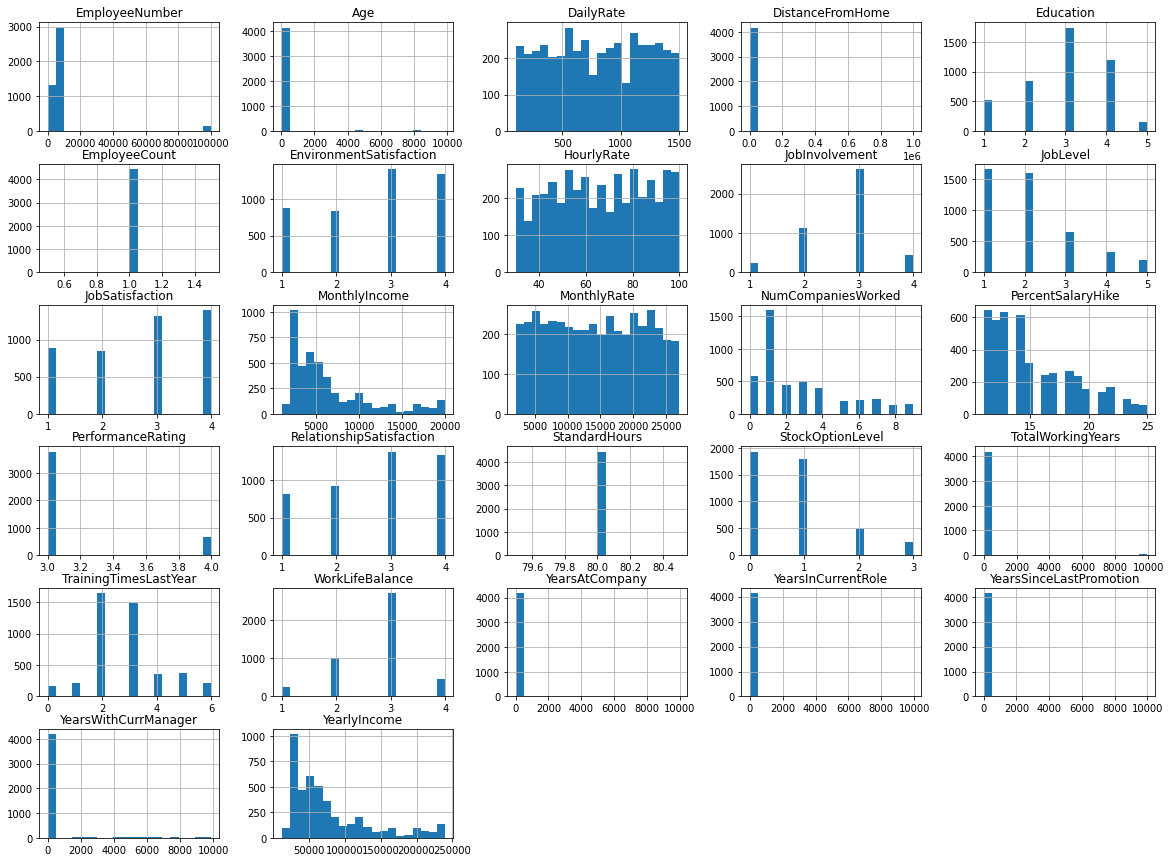

In [12]:
%matplotlib inline
df.hist(bins=20, figsize=(20,15))
plt.show()

### Clean, Prepare & Features Engineering
1. Imputation (missing data)
2. Handling outliers
3. Binning (pd.cut(data['value'], bins=[0,30,70,100], labels=["Low", "Mid", "High"]))
4. One-hot encoding (pd.get_dummies)
5. Duplicates
6. Extracting the parts of the date into different columns
7. Scaling (Normalization/Standardization)

In [13]:
# pozbycie się kolumn EmployeeNumber i Over18, jedna może zaburzać wyniki, a druga nic nie wnosi
df = drop_columns(df, ["EmployeeNumber", "Over18"])

In [14]:
# odłożenie zbioru bez wartości w kolumnie Attrition
attrition_df, df = separate_df_by_label(df)

In [15]:
attrition_df

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,YearlyIncome
1323,35.0,Travel_Rarely,1343.0,Research & Development,27.0,1.0,Medical,1.0,3.0,Female,...,0.0,6.0,3.0,2.0,6.0,5.0,1.0,1.0,NaN,30708.0
1324,27.0,Travel_Rarely,1220.0,Research & Development,5.0,3.0,Life Sciences,1.0,3.0,Female,...,0.0,4.0,2.0,2.0,4.0,3.0,1.0,2.0,NaN,29736.0
1325,24.0,Travel_Rarely,1476.0,Sales,4.0,1.0,Medical,1.0,4.0,Female,...,2.0,5.0,3.0,3.0,5.0,4.0,0.0,3.0,NaN,49944.0
1326,37.0,Non-Travel,142.0,Sales,9.0,4.0,Medical,1.0,1.0,Male,...,1.0,9.0,6.0,3.0,9.0,5.0,7.0,7.0,NaN,106008.0
1327,33.0,Travel_Rarely,527.0,Research & Development,1.0,4.0,Other,1.0,4.0,Male,...,0.0,10.0,2.0,2.0,10.0,9.0,7.0,8.0,NaN,32232.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,35.0,Non-Travel,208.0,Research & Development,8.0,4.0,Life Sciences,1.0,3.0,Female,...,1.0,15.0,5.0,3.0,14.0,11.0,2.0,9.0,NaN,49776.0
1466,41.0,Travel_Rarely,582.0,Research & Development,28.0,4.0,Life Sciences,1.0,1.0,Female,...,1.0,21.0,3.0,3.0,20.0,7.0,0.0,10.0,NaN,162840.0
1467,42.0,Travel_Rarely,1396.0,Research & Development,6.0,3.0,Medical,1.0,3.0,Male,...,1.0,18.0,3.0,4.0,13.0,7.0,5.0,7.0,NaN,160176.0
1468,44.0,Travel_Rarely,621.0,Research & Development,15.0,3.0,Medical,1.0,1.0,Female,...,1.0,10.0,2.0,3.0,10.0,7.0,0.0,5.0,NaN,95736.0


In [16]:
# usunięcie ze zbioru wartości odstających
df = delete_outliers(df)
df

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,YearlyIncome
0,30.0,Travel_Rarely,852.0,Research & Development,1.0,1.0,Life Sciences,1.0,4.0,Male,...,2.0,10.0,1.0,2.0,10.0,8.0,3.0,0.0,No,61512.0
1,38.0,Travel_Rarely,397.0,Research & Development,2.0,2.0,Medical,1.0,4.0,Female,...,1.0,10.0,6.0,4.0,5.0,4.0,0.0,2.0,No,93072.0
2,26.0,Travel_Rarely,841.0,Research & Development,6.0,3.0,Other,1.0,3.0,Female,...,0.0,5.0,3.0,2.0,5.0,4.0,4.0,3.0,No,28416.0
3,28.0,Travel_Rarely,1117.0,Research & Development,8.0,2.0,Life Sciences,1.0,4.0,Female,...,0.0,5.0,3.0,3.0,5.0,3.0,0.0,2.0,No,39720.0
4,35.0,Travel_Rarely,464.0,Research & Development,4.0,2.0,Other,1.0,3.0,Male,...,1.0,1.0,3.0,3.0,1.0,0.0,0.0,0.0,No,23412.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4425,29.0,Travel_Rarely,1210.0,Sales,2.0,3.0,Medical,1.0,1.0,Male,...,2.0,10.0,2.0,3.0,0.0,0.0,0.0,0.0,Yes,79728.0
4426,29.0,Travel_Rarely,1210.0,Sales,2.0,3.0,Medical,1.0,1.0,Male,...,2.0,10.0,2.0,3.0,0.0,0.0,0.0,0.0,Yes,79728.0
4427,29.0,Travel_Rarely,1210.0,Sales,2.0,3.0,Medical,1.0,1.0,Male,...,2.0,10.0,2.0,3.0,0.0,0.0,0.0,0.0,Yes,79728.0
4431,55.0,Travel_Rarely,725.0,Research & Development,2.0,3.0,Medical,1.0,4.0,Male,...,1.0,24.0,2.0,3.0,5.0,2.0,1.0,4.0,Yes,238308.0


In [17]:
df.dtypes

Age                         float64
BusinessTravel               object
DailyRate                   float64
Department                   object
DistanceFromHome            float64
Education                   float64
EducationField               object
EmployeeCount               float64
EnvironmentSatisfaction     float64
Gender                       object
HourlyRate                  float64
JobInvolvement              float64
JobLevel                    float64
JobRole                      object
JobSatisfaction             float64
MaritalStatus                object
MonthlyIncome               float64
MonthlyRate                 float64
NumCompaniesWorked          float64
OverTime                     object
PercentSalaryHike           float64
PerformanceRating           float64
RelationshipSatisfaction    float64
StandardHours               float64
StockOptionLevel            float64
TotalWorkingYears           float64
TrainingTimesLastYear       float64
WorkLifeBalance             

In [18]:
# one hot encoding
categorical_columns = ['BusinessTravel', "MaritalStatus", "OverTime", "EducationField", "JobRole", "Department", "Gender", "Attrition"]
df = get_one_hot_encoding_df(df, categorical_columns)
df

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,Department_Research & Development,Department_Sales,Gender_Male,Attrition
0,30.0,852.0,1.0,1.0,1.0,4.0,55.0,2.0,2.0,4.0,...,0,0,0,0,0,0,1,0,1,0
1,38.0,397.0,2.0,2.0,1.0,4.0,54.0,2.0,3.0,3.0,...,0,1,0,0,0,0,1,0,0,0
2,26.0,841.0,6.0,3.0,1.0,3.0,46.0,2.0,1.0,2.0,...,0,0,0,1,0,0,1,0,0,0
3,28.0,1117.0,8.0,2.0,1.0,4.0,66.0,3.0,1.0,4.0,...,0,0,0,1,0,0,1,0,0,0
4,35.0,464.0,4.0,2.0,1.0,3.0,75.0,3.0,1.0,4.0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4425,29.0,1210.0,2.0,3.0,1.0,1.0,78.0,2.0,2.0,2.0,...,0,0,0,0,1,0,0,1,1,1
4426,29.0,1210.0,2.0,3.0,1.0,1.0,78.0,2.0,2.0,2.0,...,0,0,0,0,1,0,0,1,1,1
4427,29.0,1210.0,2.0,3.0,1.0,1.0,78.0,2.0,2.0,2.0,...,0,0,0,0,1,0,0,1,1,1
4431,55.0,725.0,2.0,3.0,1.0,4.0,78.0,3.0,5.0,1.0,...,1,0,0,0,0,0,1,0,1,1


In [19]:
clos_to_scale = ["Age", "DailyRate", "DistanceFromHome", "Education", "HourlyRate", "MonthlyIncome", "MonthlyRate", "TotalWorkingYears", "YearlyIncome"]

In [20]:
scaled_df = get_standardized_df(df, clos_to_scale)
scaled_df

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,Department_Research & Development,Department_Sales,Gender_Male,Attrition
0,-0.765054,0.131582,-1.014477,-1.866322,1.0,4.0,-0.571827,2.0,2.0,4.0,...,0,0,0,0,0,0,1,0,1,0
1,0.113404,-1.003436,-0.891562,-0.891922,1.0,4.0,-0.621536,2.0,3.0,3.0,...,0,1,0,0,0,0,1,0,0,0
2,-1.204283,0.104142,-0.399904,0.082478,1.0,3.0,-1.019204,2.0,1.0,2.0,...,0,0,0,1,0,0,1,0,0,0
3,-0.984668,0.792636,-0.154075,-0.891922,1.0,4.0,-0.025034,3.0,1.0,4.0,...,0,0,0,1,0,0,1,0,0,0
4,-0.216018,-0.836302,-0.645733,-0.891922,1.0,3.0,0.422343,3.0,1.0,4.0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4425,-0.874861,1.024629,-0.891562,0.082478,1.0,1.0,0.571468,2.0,2.0,2.0,...,0,0,0,0,1,0,0,1,1,1
4426,-0.874861,1.024629,-0.891562,0.082478,1.0,1.0,0.571468,2.0,2.0,2.0,...,0,0,0,0,1,0,0,1,1,1
4427,-0.874861,1.024629,-0.891562,0.082478,1.0,1.0,0.571468,2.0,2.0,2.0,...,0,0,0,0,1,0,0,1,1,1
4431,1.980126,-0.185226,-0.891562,0.082478,1.0,4.0,0.571468,3.0,5.0,1.0,...,1,0,0,0,0,0,1,0,1,1


In [21]:
normalized_df = get_normalized_df(df)
normalized_df

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,Department_Research & Development,Department_Sales,Gender_Male,Attrition
0,0.285714,0.537249,0.000000,0.00,NaN,1.000000,0.357143,0.333333,0.25,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.476190,0.211318,0.035714,0.25,NaN,1.000000,0.342857,0.333333,0.50,0.666667,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.190476,0.529370,0.178571,0.50,NaN,0.666667,0.228571,0.333333,0.00,0.333333,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.238095,0.727077,0.250000,0.25,NaN,1.000000,0.514286,0.666667,0.00,1.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.404762,0.259312,0.107143,0.25,NaN,0.666667,0.642857,0.666667,0.00,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4425,0.261905,0.793696,0.035714,0.50,NaN,0.000000,0.685714,0.333333,0.25,0.333333,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
4426,0.261905,0.793696,0.035714,0.50,NaN,0.000000,0.685714,0.333333,0.25,0.333333,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
4427,0.261905,0.793696,0.035714,0.50,NaN,0.000000,0.685714,0.333333,0.25,0.333333,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
4431,0.880952,0.446275,0.035714,0.50,NaN,1.000000,0.685714,0.666667,1.00,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


### Ground Truth analysis
- check if classes are balanced 
- missing data 




In [22]:
df["Attrition"].value_counts()

0    1447
1     904
Name: Attrition, dtype: int64

### Split data 
- train, test data




In [23]:
def get_x_and_y_labels(df: pd.DataFrame, y_label="Attrition") -> tuple:
    return df.drop([y_label], axis=1), df[y_label]

In [24]:
X, y = get_x_and_y_labels(df)

In [25]:
# podział zbiorów ze stratyfikacją
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

### Data balancing 

- stratify
- undersampling (only on train data)
- oversampling (only on train data)

In [26]:
from sklearn.utils import resample

In [27]:
# df_majority = df_base[df_base['Attrition_Yes'] == 0]
# df_minority = df_base[df_base['Attrition_Yes'] == 1]
# df_minority_upsampled = resample(df_minority,
#                                  replace=True,
#                                  n_samples=803,
#                                  random_state=42)
# df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [28]:
# df_upsampled['Attrition_Yes'].value_counts()

### Evaluation metrics selection
- Accuracy 
- Precision
- Recall
- F1 score
- Confusion matrix
- ROC/ AUC

In [29]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

In [30]:
def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall:    {metrics[2]}')
    print(f'  F1 score:  {metrics[3]}')
    print(f'  Mislabeled {metrics[4]} out of {metrics[5]}')
    print('\n')

In [31]:
def calculate_metrics(target, prediction, average='weighted'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average, zero_division = 1)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, mislabeled, total

### Hyperparameters tuning and model selection

1. Select algorithms:

- Logistic regression
- SVM
- KNN
- Decision tree
- Random Forest 
- AdaBoost

2. Define list of hyperparameters for each algorithm

3. Hyperparameters tuning

- Grid search 

4. Evaluate model

5. Save best model


In [32]:
# from sklearn.svm import SVC
# svm = SVC(C = 0.0000000000000000000001, kernel="poly")
# svm.fit(X,y)
# pred = svm.predict(X)

In [33]:
from sklearn.model_selection import GridSearchCV
# parameters = {'C':[0.01, 0.1, 1, 10, 100],  'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
# searcher = GridSearchCV(svm, parameters)
# searcher.fit(X, y)
# print("Best CV params", searcher.best_params_)
# print("Best CV accuracy", searcher.best_score_)
# print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10000, max_depth = 5)
parameters = {"max_features": ["log2"]}
searcher = GridSearchCV(rf, parameters, cv = 10)
searcher.fit(X, y)
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))
rf.fit(X_train, y_train)
y_train_predict = rf.predict(X_train)
y_test_predict = rf.predict(X_test)

Best CV params {'max_features': 'log2'}
Best CV accuracy 0.6180165885322755
Test accuracy of best grid search hypers: 0.6454352441613588


In [35]:
accuracy_score(y_train, y_train_predict)

0.6691489361702128

In [36]:
accuracy_score(y_test, y_test_predict)

0.6263269639065817

In [37]:
conf_matrix = confusion_matrix(y_test, y_test_predict)

In [38]:
conf_matrix

array([[276,  14],
       [162,  19]])

In [39]:
from sklearn.metrics import plot_confusion_matrix

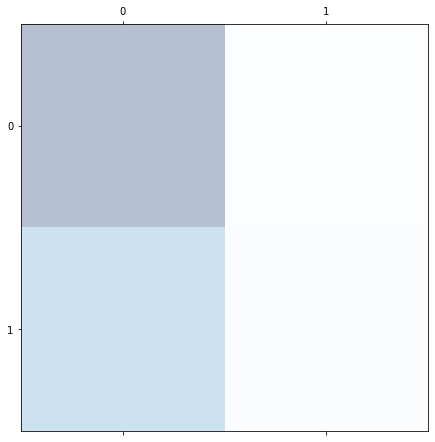

In [40]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)

In [41]:
print_results(calculate_metrics(y_test, y_test_predict), "Random Forest")
cm = confusion_matrix(y_test, y_test_predict)
plot_confusion_matrix(cm, classes)

Results for Random Forest
----
  Accuracy:  0.6263269639065817
  Precision: 0.6092395907420773
  Recall:    0.6263269639065817
  F1 score:  0.5350961715626279
  Mislabeled 176 out of 471




NameError: name 'classes' is not defined